<a href="https://colab.research.google.com/github/Yeyeong99/Aiffel/blob/main/%EC%B1%84%EB%AC%B4%EB%B6%88%EC%9D%B4%ED%96%89_without_preprocessing_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import

In [1]:
# 구글 코랩에서 한글 폰트를 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 설치된 폰트를 확인
!fc-list :lang=ko

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

## 2. Data Load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 학습/평가 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/train.csv').drop(columns=['UID'])

In [5]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv').drop(columns=['UID'])

In [29]:
train_df = df.drop(['채무 불이행 여부'], axis = 1)
target = df['채무 불이행 여부']

In [30]:
train_df.head()

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수
0,자가,1941337.5,10년 이상,0.0,9,13.4,400597.5,0,24,1,부채 통합,단기 상환,390903.0,225457.5,8806.5,767
1,월세,1979505.0,10년 이상,0.0,5,15.1,360679.5,0,11,0,부채 통합,단기 상환,1002184.5,64749.0,24961.5,767
2,월세,1356381.0,4년,0.0,12,18.8,491770.5,1,74,3,부채 통합,단기 상환,227775.0,487644.0,12069.0,800
3,월세,1049017.5,6년,0.0,15,14.8,411546.0,1,22,1,부채 통합,단기 상환,251383.5,413211.0,31749.0,796
4,월세,4320217.5,2년,0.0,11,26.1,895288.5,0,32,0,부채 통합,장기 상환,1163176.5,78991.5,5862.0,751


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  object 
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  object 
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  int64  
 5   신용 거래 연수           10000 non-null  float64
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  object 
 11  대출 상환 기간           10000 non-null  object 
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  int64  
dtypes: float64(7), int64(5)

## 2. 데이터 전처리

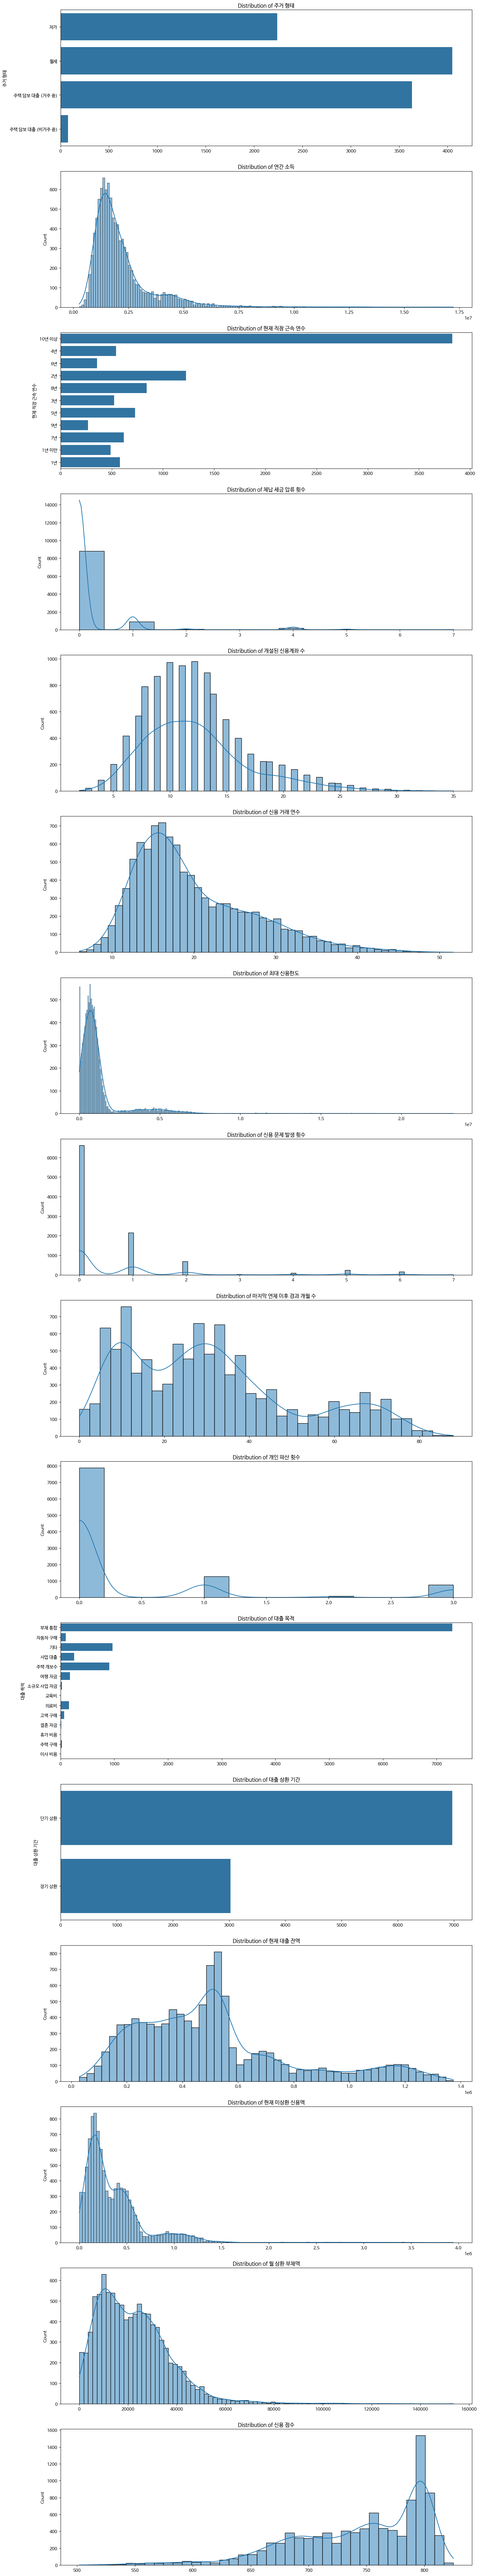

In [9]:
# 수치형 칼럼과 범주형 칼럼 분리
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns

# 그래프 설정
fig, axes = plt.subplots(len(train_df.columns), 1, figsize=(15, 5*len(train_df.columns)), squeeze=False)

# 각 칼럼에 대한 그래프 생성
for i, column in enumerate(train_df.columns):
    if column in numeric_columns:
        sns.histplot(train_df[column], ax=axes[i,0], kde=True)
    else:
        sns.countplot(y=train_df[column], ax=axes[i,0])

    axes[i,0].set_title(f'Distribution of {column}')
    axes[i,0].set_xlabel('')

plt.tight_layout()
plt.show()

In [10]:
import scipy.stats as stats
skew_threshold = 0.5
for col in train_df.columns:
    if train_df[col].dtype in ['int64', 'float64']:
        skewness = stats.skew(train_df[col]) # 왜도
        print(f"{col} 왜도: {skewness:.4f}")
        if abs(skewness) > skew_threshold:
            if skewness > 0:  # 왼으로 치우친 경우
                train_df[f"{col}_transformed"] = np.log1p(train_df[col])
                print(f"  왼쪽으로 치우침. 로그 변환 적용.")
            else:  # 오른쪽으로 치우친 경우
                train_df[f"{col}_transformed"] = train_df[col] ** 3
                print(f"  오른쪽으로 치우침. 제곱 변환 적용.")


연간 소득 왜도: 2.9235
  왼쪽으로 치우침. 로그 변환 적용.
체납 세금 압류 횟수 왜도: 5.0245
  왼쪽으로 치우침. 로그 변환 적용.
개설된 신용계좌 수 왜도: 0.9125
  왼쪽으로 치우침. 로그 변환 적용.
신용 거래 연수 왜도: 0.9876
  왼쪽으로 치우침. 로그 변환 적용.
최대 신용한도 왜도: 4.4825
  왼쪽으로 치우침. 로그 변환 적용.
신용 문제 발생 횟수 왜도: 2.8051
  왼쪽으로 치우침. 로그 변환 적용.
마지막 연체 이후 경과 개월 수 왜도: 0.6628
  왼쪽으로 치우침. 로그 변환 적용.
개인 파산 횟수 왜도: 2.3662
  왼쪽으로 치우침. 로그 변환 적용.
현재 대출 잔액 왜도: 1.0242
  왼쪽으로 치우침. 로그 변환 적용.
현재 미상환 신용액 왜도: 3.3055
  왼쪽으로 치우침. 로그 변환 적용.
월 상환 부채액 왜도: 1.5335
  왼쪽으로 치우침. 로그 변환 적용.
신용 점수 왜도: -0.9803
  오른쪽으로 치우침. 제곱 변환 적용.


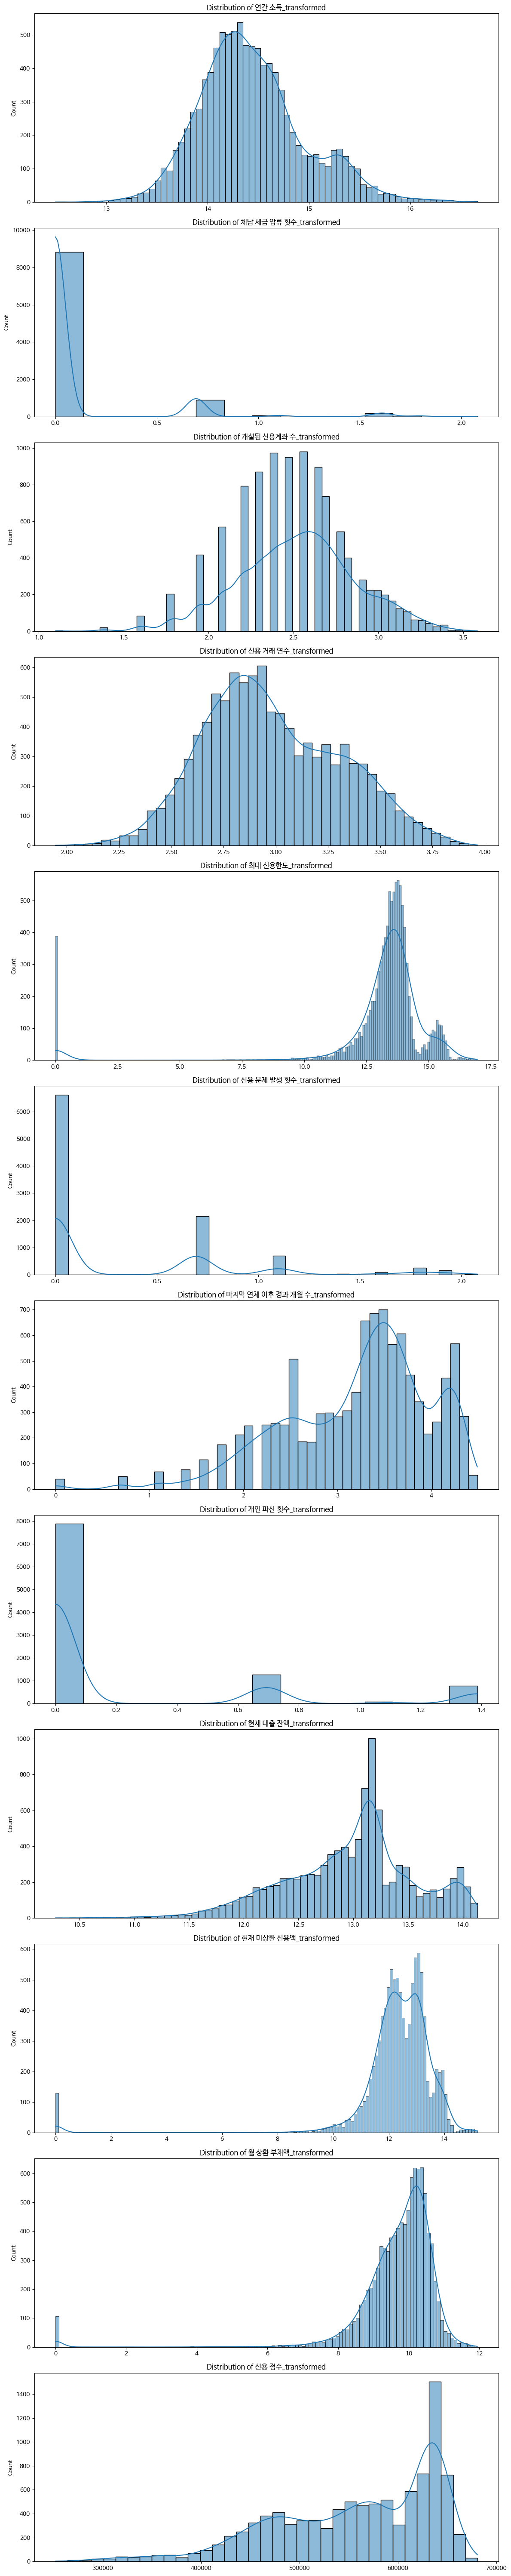

In [11]:
transformed_columns = [col for col in  train_df.columns if col.endswith('_transformed')]

# 그래프 설정
fig, axes = plt.subplots(len(transformed_columns), 1, figsize=(12, 5*len(transformed_columns)), squeeze=False)

# 각 칼럼에 대한 그래프 생성
for i, column in enumerate(transformed_columns):
    sns.histplot(train_df[column], ax=axes[i,0], kde=True)
    axes[i,0].set_title(f'Distribution of {column}')
    axes[i,0].set_xlabel('')

plt.tight_layout()
plt.show()

In [12]:
transformed_df = train_df.drop(numeric_columns, axis=1)

In [13]:
transformed_df.head()

,주거 형태,현재 직장 근속 연수,대출 목적,대출 상환 기간,연간 소득_transformed,체납 세금 압류 횟수_transformed,개설된 신용계좌 수_transformed,신용 거래 연수_transformed,최대 신용한도_transformed,신용 문제 발생 횟수_transformed,마지막 연체 이후 경과 개월 수_transformed,개인 파산 횟수_transformed,현재 대출 잔액_transformed,현재 미상환 신용액_transformed,월 상환 부채액_transformed,신용 점수_transformed
0,자가,10년 이상,부채 통합,단기 상환,14.478888,0.0,2.302585,2.667228,12.900715,0.000000,3.218876,0.693147,12.876217,12.325891,9.083359,588289
1,월세,10년 이상,부채 통합,단기 상환,14.498358,0.0,1.791759,2.778819,12.795748,0.000000,2.484907,0.000000,13.817694,11.078289,10.125130,588289
2,월세,4년,부채 통합,단기 상환,14.120331,0.0,2.564949,2.985682,13.105769,0.693147,4.317488,1.386294,12.336118,13.097343,9.398478,640000
3,월세,6년,부채 통합,단기 상환,13.863366,0.0,2.772589,2.760010,12.927679,0.693147,3.135494,0.693147,12.434739,12.931716,10.365648,633616
4,월세,2년,부채 통합,장기 상환,15.278817,0.0,2.484907,3.299534,13.704902,0.000000,3.496508,0.000000,13.966666,11.277108,8.676417,564001


In [15]:
transformed_df.head()

,주거 형태,현재 직장 근속 연수,대출 목적,대출 상환 기간,연간 소득_transformed,체납 세금 압류 횟수_transformed,개설된 신용계좌 수_transformed,신용 거래 연수_transformed,최대 신용한도_transformed,신용 문제 발생 횟수_transformed,마지막 연체 이후 경과 개월 수_transformed,개인 파산 횟수_transformed,현재 대출 잔액_transformed,현재 미상환 신용액_transformed,월 상환 부채액_transformed,신용 점수_transformed
0,자가,10년 이상,부채 통합,단기 상환,14.478888,0.0,2.302585,2.667228,12.900715,0.000000,3.218876,0.693147,12.876217,12.325891,9.083359,588289
1,월세,10년 이상,부채 통합,단기 상환,14.498358,0.0,1.791759,2.778819,12.795748,0.000000,2.484907,0.000000,13.817694,11.078289,10.125130,588289
2,월세,4년,부채 통합,단기 상환,14.120331,0.0,2.564949,2.985682,13.105769,0.693147,4.317488,1.386294,12.336118,13.097343,9.398478,640000
3,월세,6년,부채 통합,단기 상환,13.863366,0.0,2.772589,2.760010,12.927679,0.693147,3.135494,0.693147,12.434739,12.931716,10.365648,633616
4,월세,2년,부채 통합,장기 상환,15.278817,0.0,2.484907,3.299534,13.704902,0.000000,3.496508,0.000000,13.966666,11.277108,8.676417,564001



## 4. Train / Validation Split (학습 데이터 분할)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df,
    target,
    test_size=0.2,
    random_state=42
)

## 5. Model Training (모델 학습)

## 6. Prediction

In [21]:
pip install catboost

In [33]:
from catboost import CatBoostClassifier

categorical_col = [
    '주거 형태',
    '현재 직장 근속 연수',
    '대출 목적',
    '대출 상환 기간'
]

cat_model = CatBoostClassifier(
    verbose=0,
    cat_features=categorical_col)

## 모델 학습
- preprocessing 안함
- catboostclassfier 자체 categorical 변수 변경 기능 사용
- randomized_search 이용

In [34]:
param_grid = {
    'iterations': [100, 500, 1000],          # 트리 개수
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # 학습률
    'depth': [4, 6, 8, 10],                  # 트리 깊이
    'l2_leaf_reg': [1, 3, 5, 7, 9],          # L2 정규화
    'border_count': [32, 50, 100, 200],      # 분할 가능한 값 개수
    'bagging_temperature': [0.0, 0.5, 1.0]   # 배깅 온도
}
randomized_cat = cat_model.randomized_search(
    param_distributions=param_grid,
    X=X_train,
    y=y_train,
    cv=5,
    n_iter=100,  # 100개의 랜덤 조합만 탐색
    partition_random_seed=42,
    stratified=True,
    refit=True
)


bestTest = 0.5396121973
bestIteration = 52

0:	loss: 0.5396122	best: 0.5396122 (0)	total: 638ms	remaining: 1m 3s

bestTest = 0.5343113026
bestIteration = 296

1:	loss: 0.5343113	best: 0.5343113 (1)	total: 4.81s	remaining: 3m 55s

bestTest = 0.5362995828
bestIteration = 999

2:	loss: 0.5362996	best: 0.5343113 (1)	total: 14.4s	remaining: 7m 47s

bestTest = 0.5390634373
bestIteration = 499

3:	loss: 0.5390634	best: 0.5343113 (1)	total: 19.9s	remaining: 7m 56s

bestTest = 0.5416532325
bestIteration = 49

4:	loss: 0.5416532	best: 0.5343113 (1)	total: 38.6s	remaining: 12m 14s

bestTest = 0.536165069
bestIteration = 48

5:	loss: 0.5361651	best: 0.5343113 (1)	total: 52.2s	remaining: 13m 37s

bestTest = 0.5396121973
bestIteration = 52

6:	loss: 0.5396122	best: 0.5343113 (1)	total: 53.3s	remaining: 11m 47s

bestTest = 0.5344478637
bestIteration = 110

7:	loss: 0.5344479	best: 0.5343113 (1)	total: 58.9s	remaining: 11m 16s

bestTest = 0.5358795962
bestIteration = 205

8:	loss: 0.5358796	best: 0.5

In [35]:
# 최적의 하이퍼파라미터 가져오기
best_params = randomized_cat['params']
print("Best parameters found:", best_params)

# 최적 하이퍼파라미터로 새 모델 훈련
best_model = CatBoostClassifier(**best_params, cat_features=categorical_col, verbose=100)
best_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),  # 검증 데이터 추가
    use_best_model=True
)

Best parameters found: {'border_count': 50, 'bagging_temperature': 0.5, 'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 500}
0:	learn: 0.6792383	test: 0.6817587	best: 0.6817587 (0)	total: 18.7ms	remaining: 9.32s
100:	learn: 0.4579551	test: 0.5733920	best: 0.5733920 (100)	total: 1.58s	remaining: 6.24s
200:	learn: 0.3972989	test: 0.5797076	best: 0.5733920 (100)	total: 3.35s	remaining: 4.99s
300:	learn: 0.3379175	test: 0.5852308	best: 0.5733920 (100)	total: 6.79s	remaining: 4.49s
400:	learn: 0.2891089	test: 0.5922822	best: 0.5733920 (100)	total: 8.46s	remaining: 2.09s
499:	learn: 0.2487892	test: 0.6001314	best: 0.5733920 (100)	total: 10.1s	remaining: 0us

bestTest = 0.5733920236
bestIteration = 100

Shrink model to first 101 iterations.


In [ ]:
import scipy.stats as stats
skew_threshold = 0.5
for col in test_df.columns:
    if test_df[col].dtype in ['int64', 'float64']:
        skewness = stats.skew(test_df[col]) # 왜도
        print(f"{col} 왜도: {skewness:.4f}")
        if abs(skewness) > skew_threshold:
            if skewness > 0:  # 왼으로 치우친 경우
                test_df[f"{col}_transformed"] = np.log1p(test_df[col])
                print(f"  왼쪽으로 치우침. 로그 변환 적용.")
            else:  # 오른쪽으로 치우친 경우
                test_df[f"{col}_transformed"] = test_df[col] ** 2
                print(f"  오른쪽으로 치우침. 제곱 변환 적용.")
        else:
            test_df[f"{col}_transformed"] = test_df[col]


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   주거 형태                          10000 non-null  object 
 1   연간 소득                          10000 non-null  float64
 2   현재 직장 근속 연수                    10000 non-null  object 
 3   체납 세금 압류 횟수                    10000 non-null  float64
 4   개설된 신용계좌 수                     10000 non-null  int64  
 5   신용 거래 연수                       10000 non-null  float64
 6   최대 신용한도                        10000 non-null  float64
 7   신용 문제 발생 횟수                    10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수              10000 non-null  int64  
 9   개인 파산 횟수                       10000 non-null  int64  
 10  대출 목적                          10000 non-null  object 
 11  대출 상환 기간                       10000 non-null  object 
 12  현재 대출 잔액                       10000 non-null  

In [ ]:
numeric_columns_test = [n for n in numeric_columns if n != '채무 불이행 여부']
transformed_test_df = test_df.drop(numeric_columns_test, axis=1)

In [ ]:
transformed_test_df.head()

In [ ]:
# numeric_columns_transformed_test = transformed_test_df.select_dtypes(include=['int64', 'float64']).columns

# transformed_test_df[numeric_columns_transformed_test] = scaler.fit_transform(transformed_test_df[numeric_columns_transformed_test])

In [ ]:
transformed_test_df.head()

In [ ]:
transformed_test_df.info()

In [ ]:
transformed_df.info()

In [36]:
# 최적 모델 성능 출력
probs = best_model.predict_proba(test_df)[:, 1]
probs

array([0.3462924 , 0.29017906, 0.33057415, ..., 0.28694307, 0.37987659,
       0.67409682])

In [38]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = probs
submit.to_csv('/content/drive/MyDrive/submission_catboost_radomized_not_preprocessing.csv', encoding='UTF-8-sig', index=False)